<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Connect Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os

# # Change to the directory where project is located
# os.chdir('/content/drive/MyDrive/College/MSc/2nd Semester/Deep Learning/project')

# # Verify that we changed the directory
# print("Changed directory to:", os.getcwd())

## 1.2 Import Libraries

In [3]:
# # # Google Colab
# !pip install keras_cv

In [4]:
import pandas as pd
import zipfile
import pickle
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import regularizers
from classes import *
from functions import *

/Users/mgalao/Library/CloudStorage/OneDrive-NOVAIMS/MSc_DSAA-DS/2nd Semester/Q3 Deep Learning/deep-learning-project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import optimizers

## 1.3 Import Dataset

The amount of data we have is not supported by GitHub (where we have our project stored). The solution is: create a folder named data and allocate the rare_species file inside it. The gitignore file makes sure this folder is not used when we are pulling or pushing changes but everyone needs to have it on their machines locally. A random seed was used to ensure that the splits stay the same. 

In [6]:
# # Google Colab

# # Define the path to the zip file and the extraction folder
# zip_path = Path("../data/rare_species.zip")

# # Get the directory where the zip file is located
# extract_path = Path("../data/rare_species")

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [7]:
# Import Metadata
metadata_path = Path("../data/rare_species/metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [8]:
df.shape # 11983 images

(11983, 7)

<div class="alert alert-block alert-success">

# **2.** Feature Engineering 

<div>

In [ ]:
# # Encode family (target) and phylum (metadata feature)
family_encoder = LabelEncoder()
phylum_encoder = LabelEncoder()
df["family_encoded"] = family_encoder.fit_transform(df["family"]) # used in preprocess.load_img
df["phylum_encoded"] = phylum_encoder.fit_transform(df["phylum"])

# # Check the number of unique families and phyla
# num_families = df["family_encoded"].nunique()
# num_phyla = df["phylum_encoded"].nunique()
# print(f"Number of unique phyla: {num_phyla}")
# print(f"Number of unique families: {num_families}")

# # One-hot encode the family and phylum columns
# df["phylum_onehot"] = df["phylum_encoded"].apply(lambda x: tf.one_hot(x, depth=num_phyla).numpy())
# df["family_onehot"] = df["family_encoded"].apply(lambda x: tf.one_hot(x, depth=num_families).numpy())

# # Create a new column for the full file path
# # Windows
# # df["full_file_path"] = df["file_path"].apply(lambda x: os.path.join(path, x.replace("/", "\\")))
# # Mac
# df["full_file_path"] = df["file_path"].apply(lambda x: str(Path("../data/rare_species") / x))

# # Increase display width
# # pd.set_option('display.max_colwidth', None)
# # pd.reset_option('display.max_colwidth')
# df.head()

<div class="alert alert-block alert-success">

# **3.** Preprocessing

<div>

In [10]:
#Load the DataFrames from the .pkl files
with open("../data/train_df.pkl", "rb") as f:
     train_df = pickle.load(f)

with open("../data/valid_df.pkl", "rb") as f:
     val_df = pickle.load(f)

with open("../data/test_df.pkl", "rb") as f:
     test_df = pickle.load(f)

In [12]:
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)

preprocess = Preprocessor_with_phylum(image_size=image_size, batch_size=batch_size)

2025-04-15 22:08:15.176913: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-15 22:08:15.177062: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-15 22:08:15.177067: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-15 22:08:15.177423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-15 22:08:15.177435: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# identify the minority class
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

train_ds, class_names = preprocess.load_img(train_df, minority_class=minority_class, family_encoder=family_encoder, augment='mixup', oversampling=True)
# train_ds_sampled, class_names = preprocess.load_img(data_dir="../data/rare_species/train_sampled", minority_class=minority_class, augment=None, oversampling=True)
val_ds, _ = preprocess.load_img(val_df, minority_class=minority_class, family_encoder=family_encoder, augment=None, oversampling=False)
test_ds, _ = preprocess.load_img(test_df, minority_class=minority_class, family_encoder=family_encoder, augment=None, oversampling=False)

<div class="alert alert-block alert-success">

# **4.** Models

<div>

## ResNet50 - Margarida - com preprocessing + Phylum

### Before (Marco)

In [16]:
# # Build datasets
# train_ds, class_names = build_ds_with_phylum_augmented(
#     df=train_df,
#     data_dir="../data/rare_species/train",
#     preprocess=preprocess,
#     minority_class=minority_class,
#     augment='mixup',
#     oversampling=False
# )

# val_ds, _ = build_ds_with_phylum_augmented(
#     df=valid_df,
#     data_dir="../data/rare_species/val",
#     preprocess=preprocess,
#     augment=None,
#     oversampling=False
# )

# test_ds, _ = build_ds_with_phylum_augmented(
#     df=test_df,
#     data_dir="../data/rare_species/test",
#     preprocess=preprocess,
#     augment=None,
#     oversampling=False
# )

In [17]:
# for batch in train_ds.take(1):
#     x, y = batch
#     print("Input keys:", x.keys())
#     print("Image input shape:", x["image_input"].shape)
#     print("Phylum input shape:", x["phylum_input"].shape)
#     print("Label shape:", y.shape)

In [18]:
# # Image input
# image_input = Input(shape=(224, 224, 3), name="image_input")
# base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=image_input)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)

# # Phylum input
# phylum_input = Input(shape=(5,), name="phylum_input")

# # Combine both
# combined = Concatenate()([x, phylum_input])
# combined = Dense(256, activation='relu')(combined)
# combined = Dropout(0.3)(combined)
# output = Dense(202, activation='softmax')(combined)

# model = Model(inputs=[image_input, phylum_input], outputs=output)

# # Define the metrics
# metrics = [
#     CategoricalAccuracy(name="accuracy"),
#     AUC(name="auc"),
#     F1Score(average="macro", name="f1_macro"),
#     F1Score(average="weighted", name="f1_weighted"),
#     TopKCategoricalAccuracy(k=5, name="top5_accuracy")
# ]

# # Compile the model
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=metrics
# )

<!-- 
TopKCategoricalAccuracy(k=5): https://www.tensorflow.org/api_docs/python/tf/keras/metrics/TopKCategoricalAccuracy

This is a more forgiving metric. It considers a prediction correct if the true label is among the model’s top 5 predictions (sorted by probability).
Useful when there are many classes (like 202 families) — even if top-1 is hard, top-5 can still show useful trends -->

In [19]:
# # Initialize the experiment
# experiment = Experiment(
#     model=model,
#     train_ds=train_ds,
#     val_ds=val_ds,
#     experiment_name="resnet50_phylum_aug-mixup",
#     resume=False
# )

# # Default callbacks
# # ExperimentLogger,  # Log experiment results after each epoch
# # EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# # ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# # Add callbacks
# # callbacks = [

# # ]

# # Run the experiment
# # resume=False means start from scratch, resume=True means continue from last checkpoint)
# # callbacks=None use default callbacks (created in the Experiment class)
# history = experiment.run_experiment(callbacks=None, epochs=50)

### Original

In [20]:
# Architecture Concept
# 
#           [Image]
#             ↓
#      [ResNet50 Base]
#             ↓
#  [GlobalAvgPooling2D]  ←  [Phylum Input]
#             ↓                  ↓
#        [Dense 256]         [Dense 32]
#               ↘           ↙
#                [Concatenate]
#                       ↓
#              [Dense 128 + Dropout]
#                       ↓
#                [Softmax over 202]
# 

In [23]:
# Image input
image_input = Input(shape=(224, 224, 3), name="image_input")
base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=image_input)
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Phylum input
phylum_input = Input(shape=(5,), name="phylum_input")

# Combine both
combined = Concatenate()([x, phylum_input])
combined = Dense(256, activation='relu')(combined)
combined = Dropout(0.3)(combined)
output = Dense(202, activation='softmax')(combined)

model = Model(inputs=[image_input, phylum_input], outputs=output)

# Define the metrics
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_macro"),
    F1Score(average="weighted", name="f1_weighted"),
    TopKCategoricalAccuracy(k=5, name="top5_accuracy")
]

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

In [ ]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_phylum_aug-mixup",
    resume=False,
)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Add callbacks
# callbacks = [

# ]

# Run the experiment
# resume=False means start from scratch, resume=True means continue from last checkpoint)
# callbacks=None use default callbacks (created in the Experiment class)
history = experiment.run_experiment(callbacks=None, epochs=50)

Epoch 1/50


2025-04-15 22:08:23.390800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/mgalao/Library/CloudStorage/OneDrive-NOVAIMS/MSc_DSAA-DS/2nd Semester/Q3 Deep Learning/deep-learning-project/venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


350/350 ━━━━━━━━━━━━━━━━━━━━ 79s 226ms/step - val_accuracy: 0.0022 - val_auc: 0.4780 - val_f1_macro: 2.1990e-05 - val_f1_weighted: 9.8875e-06 - val_loss: 5.6621 - val_top5_accuracy: 0.0195
Epoch 2/50


2025-04-15 22:09:37.482357: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


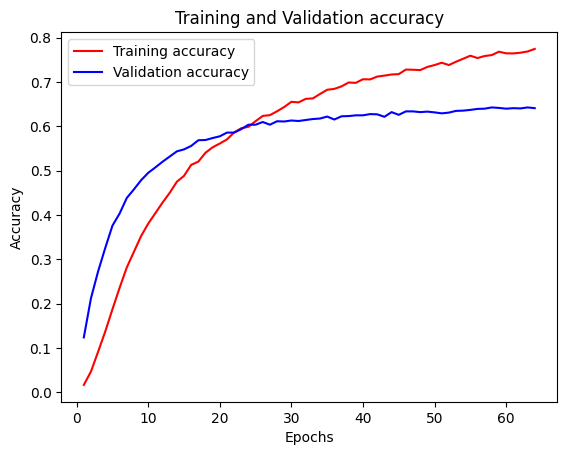

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plot_model_acc(num_epochs=64, train_acc=acc_train, val_acc=acc_val)

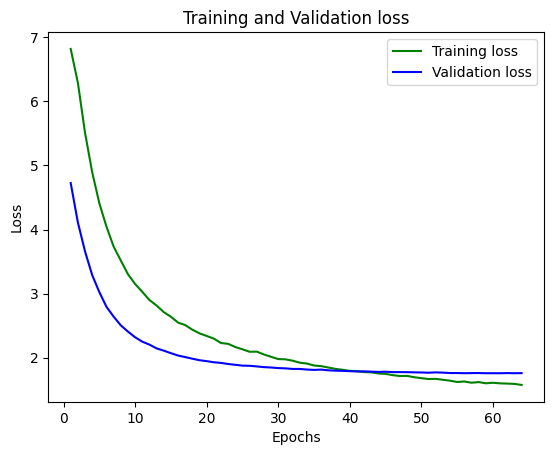

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plot_model_loss(num_epochs=64, train_loss=loss_train, val_loss=loss_val)

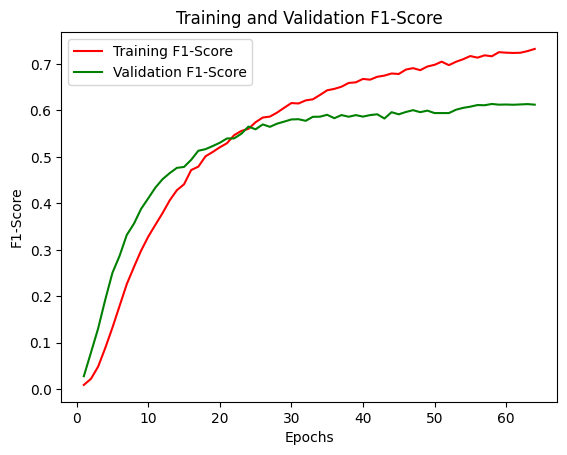

In [ ]:
x_axis = range(1,64+1)
plt.plot(x_axis, history.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

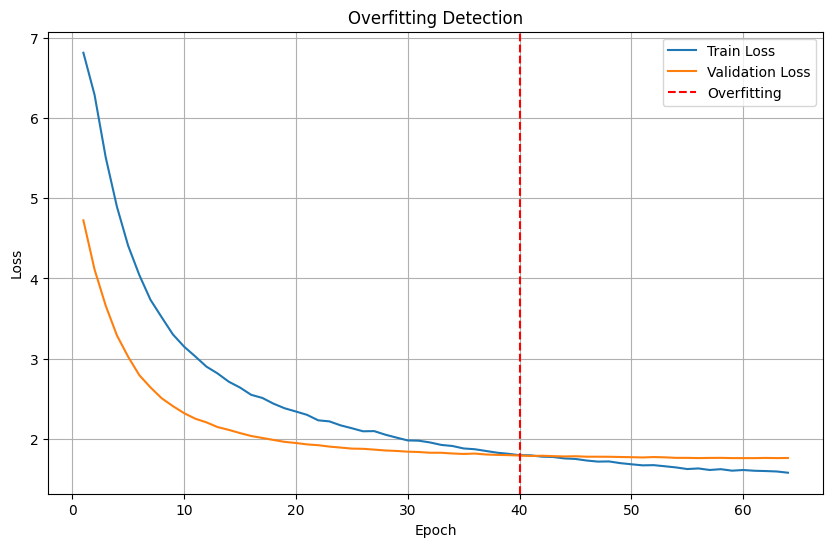

In [ ]:
epochs = range(1, len(loss_train) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train, label='Train Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.axvline(x=40, color='r', linestyle='--', label='Overfitting')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overfitting Detection')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
epochs = range(1, len(loss_train) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train, label='Train Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.axvline(x=40, color='r', linestyle='--', label='Overfitting')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overfitting Detection')
plt.legend()
plt.grid(True)
plt.show()

## ResNet50 - Margarida - com preprocessing

### Original

In [34]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [18]:
# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=[],
    augment='mixup',
    oversampling=True,
    preprocessing_function=preprocess_input)

val_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [19]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)


In [ ]:
input_img = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=metrics
)

In [16]:
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_with_preprocessing_pre_finetuning",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,           # Reduce LR if no improvement after 2 epochs
        min_lr=1e-6,
        verbose=1
    )]
    
# Run the experiment
history = experiment.run_experiment(callbacks=callbacks_additional, epochs=100) # callbacks=None use default callbacks (created in the Experiment class)

No checkpoint found, starting from scratch.
Epoch 1/100


/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
2025-04-12 22:36:03.801260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.0102 - auc: 0.5213 - f1_score: 0.0061 - loss: 6.8408

2025-04-12 22:38:31.452462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(43, 224, 224, 3))
  warnings.warn(msg)


263/263 ━━━━━━━━━━━━━━━━━━━━ 130s 486ms/step


2025-04-12 22:40:42.058662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 313ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.0102 - auc: 0.5213 - f1_score: 0.0061 - loss: 6.8407 - val_accuracy: 0.1241 - val_auc: 0.7289 - val_f1_score: 0.0280 - val_loss: 4.7248 - learning_rate: 1.0000e-04
Epoch 2/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.0396 - auc: 0.5666 - f1_score: 0.0182 - loss: 6.4499

2025-04-12 22:43:30.846022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 117s 445ms/step


2025-04-12 22:45:28.748213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 309ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.0396 - auc: 0.5666 - f1_score: 0.0182 - loss: 6.4493 - val_accuracy: 0.2126 - val_auc: 0.8024 - val_f1_score: 0.0791 - val_loss: 4.1113 - learning_rate: 1.0000e-04
Epoch 3/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0794 - auc: 0.6006 - f1_score: 0.0381 - loss: 5.6843

2025-04-12 23:11:12.982821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 158s 592ms/step


2025-04-12 23:13:51.549775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 304ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1702s 6s/step - accuracy: 0.0794 - auc: 0.6006 - f1_score: 0.0381 - loss: 5.6836 - val_accuracy: 0.2732 - val_auc: 0.8567 - val_f1_score: 0.1308 - val_loss: 3.6592 - learning_rate: 1.0000e-04
Epoch 4/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.1210 - auc: 0.6372 - f1_score: 0.0722 - loss: 5.0067

2025-04-12 23:16:50.394127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 468ms/step


2025-04-12 23:18:54.587989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.1211 - auc: 0.6372 - f1_score: 0.0722 - loss: 5.0063 - val_accuracy: 0.3261 - val_auc: 0.8931 - val_f1_score: 0.1931 - val_loss: 3.2896 - learning_rate: 1.0000e-04
Epoch 5/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.1723 - auc: 0.6627 - f1_score: 0.1146 - loss: 4.5021

2025-04-12 23:21:51.802883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 172s 653ms/step


2025-04-12 23:24:44.494343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 48s 307ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.1723 - auc: 0.6627 - f1_score: 0.1147 - loss: 4.5017 - val_accuracy: 0.3762 - val_auc: 0.9147 - val_f1_score: 0.2506 - val_loss: 3.0241 - learning_rate: 1.0000e-04
Epoch 6/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2215 - auc: 0.6818 - f1_score: 0.1585 - loss: 4.1302

2025-04-12 23:54:04.040916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 606s 2s/step


2025-04-13 00:04:10.752806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 307ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 2337s 9s/step - accuracy: 0.2216 - auc: 0.6818 - f1_score: 0.1586 - loss: 4.1299 - val_accuracy: 0.4035 - val_auc: 0.9297 - val_f1_score: 0.2872 - val_loss: 2.7939 - learning_rate: 1.0000e-04
Epoch 7/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2625 - auc: 0.7021 - f1_score: 0.1948 - loss: 3.8037

2025-04-13 00:34:09.484411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 635s 2s/step


2025-04-13 00:44:45.559037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 324ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 2436s 9s/step - accuracy: 0.2626 - auc: 0.7021 - f1_score: 0.1949 - loss: 3.8034 - val_accuracy: 0.4385 - val_auc: 0.9375 - val_f1_score: 0.3319 - val_loss: 2.6411 - learning_rate: 1.0000e-04
Epoch 8/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.3051 - auc: 0.7115 - f1_score: 0.2388 - loss: 3.5686

2025-04-13 00:47:47.985534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 118s 448ms/step


2025-04-13 00:49:46.982560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 310ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.3052 - auc: 0.7115 - f1_score: 0.2389 - loss: 3.5684 - val_accuracy: 0.4580 - val_auc: 0.9452 - val_f1_score: 0.3561 - val_loss: 2.5056 - learning_rate: 1.0000e-04
Epoch 9/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.3390 - auc: 0.7226 - f1_score: 0.2726 - loss: 3.3438

2025-04-13 00:52:36.860247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 456ms/step


2025-04-13 00:54:37.809758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.3391 - auc: 0.7226 - f1_score: 0.2727 - loss: 3.3436 - val_accuracy: 0.4786 - val_auc: 0.9498 - val_f1_score: 0.3880 - val_loss: 2.4079 - learning_rate: 1.0000e-04
Epoch 10/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.3745 - auc: 0.7289 - f1_score: 0.3065 - loss: 3.1775

2025-04-13 00:57:35.066865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 118s 449ms/step


2025-04-13 00:59:33.902831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.3745 - auc: 0.7289 - f1_score: 0.3066 - loss: 3.1774 - val_accuracy: 0.4953 - val_auc: 0.9534 - val_f1_score: 0.4108 - val_loss: 2.3200 - learning_rate: 1.0000e-04
Epoch 11/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.3931 - auc: 0.7364 - f1_score: 0.3249 - loss: 3.0614

2025-04-13 01:02:27.415790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 118s 449ms/step


2025-04-13 01:04:26.332641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.3932 - auc: 0.7364 - f1_score: 0.3250 - loss: 3.0612 - val_accuracy: 0.5075 - val_auc: 0.9551 - val_f1_score: 0.4339 - val_loss: 2.2509 - learning_rate: 1.0000e-04
Epoch 12/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.4187 - auc: 0.7383 - f1_score: 0.3502 - loss: 2.9363

2025-04-13 01:07:22.232483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 453ms/step


2025-04-13 01:09:22.140623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.4187 - auc: 0.7383 - f1_score: 0.3503 - loss: 2.9362 - val_accuracy: 0.5203 - val_auc: 0.9568 - val_f1_score: 0.4520 - val_loss: 2.2051 - learning_rate: 1.0000e-04
Epoch 13/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.4433 - auc: 0.7415 - f1_score: 0.3790 - loss: 2.8416

2025-04-13 01:12:20.421792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 451ms/step


2025-04-13 01:14:19.916028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 317ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.4433 - auc: 0.7415 - f1_score: 0.3791 - loss: 2.8415 - val_accuracy: 0.5320 - val_auc: 0.9583 - val_f1_score: 0.4650 - val_loss: 2.1460 - learning_rate: 1.0000e-04
Epoch 14/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.4692 - auc: 0.7469 - f1_score: 0.4004 - loss: 2.7301

2025-04-13 01:17:18.518704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 458ms/step


2025-04-13 01:19:19.583632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 324ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.4693 - auc: 0.7469 - f1_score: 0.4005 - loss: 2.7300 - val_accuracy: 0.5437 - val_auc: 0.9595 - val_f1_score: 0.4763 - val_loss: 2.1113 - learning_rate: 1.0000e-04
Epoch 15/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.4860 - auc: 0.7497 - f1_score: 0.4153 - loss: 2.6563

2025-04-13 01:22:18.963023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 128s 484ms/step


2025-04-13 01:24:27.066985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 325ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.4860 - auc: 0.7497 - f1_score: 0.4154 - loss: 2.6563 - val_accuracy: 0.5481 - val_auc: 0.9598 - val_f1_score: 0.4783 - val_loss: 2.0713 - learning_rate: 1.0000e-04
Epoch 16/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.5038 - auc: 0.7535 - f1_score: 0.4412 - loss: 2.5687

2025-04-13 01:27:26.868656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 450ms/step


2025-04-13 01:29:25.949296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 326ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.5039 - auc: 0.7535 - f1_score: 0.4413 - loss: 2.5686 - val_accuracy: 0.5559 - val_auc: 0.9596 - val_f1_score: 0.4937 - val_loss: 2.0350 - learning_rate: 1.0000e-04
Epoch 17/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.5125 - auc: 0.7501 - f1_score: 0.4445 - loss: 2.5324

2025-04-13 01:32:25.929540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 456ms/step


2025-04-13 01:34:26.687995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 323ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.5125 - auc: 0.7501 - f1_score: 0.4446 - loss: 2.5323 - val_accuracy: 0.5687 - val_auc: 0.9621 - val_f1_score: 0.5132 - val_loss: 2.0104 - learning_rate: 1.0000e-04
Epoch 18/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.5366 - auc: 0.7566 - f1_score: 0.4717 - loss: 2.4547

2025-04-13 01:37:26.849877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 459ms/step


2025-04-13 01:39:28.248621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 340ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.5366 - auc: 0.7566 - f1_score: 0.4718 - loss: 2.4546 - val_accuracy: 0.5693 - val_auc: 0.9610 - val_f1_score: 0.5165 - val_loss: 1.9854 - learning_rate: 1.0000e-04
Epoch 19/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.5472 - auc: 0.7576 - f1_score: 0.4781 - loss: 2.3957

2025-04-13 01:42:32.503137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 469ms/step


2025-04-13 01:44:36.721537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.5472 - auc: 0.7576 - f1_score: 0.4782 - loss: 2.3956 - val_accuracy: 0.5737 - val_auc: 0.9620 - val_f1_score: 0.5232 - val_loss: 1.9615 - learning_rate: 1.0000e-04
Epoch 20/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.5563 - auc: 0.7601 - f1_score: 0.4898 - loss: 2.3448

2025-04-13 01:47:37.873955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step


2025-04-13 01:55:55.157146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 312ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 678s 3s/step - accuracy: 0.5563 - auc: 0.7601 - f1_score: 0.4899 - loss: 2.3447 - val_accuracy: 0.5776 - val_auc: 0.9636 - val_f1_score: 0.5304 - val_loss: 1.9474 - learning_rate: 1.0000e-04
Epoch 21/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5662 - auc: 0.7622 - f1_score: 0.4941 - loss: 2.3128

2025-04-13 02:14:50.796874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 134s 506ms/step


2025-04-13 02:17:05.431552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1272s 5s/step - accuracy: 0.5662 - auc: 0.7622 - f1_score: 0.4943 - loss: 2.3128 - val_accuracy: 0.5860 - val_auc: 0.9632 - val_f1_score: 0.5396 - val_loss: 1.9299 - learning_rate: 1.0000e-04
Epoch 22/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.5768 - auc: 0.7640 - f1_score: 0.5089 - loss: 2.2499

2025-04-13 02:20:28.437808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 123s 466ms/step


2025-04-13 02:22:32.216680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 337ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.5768 - auc: 0.7640 - f1_score: 0.5090 - loss: 2.2499 - val_accuracy: 0.5860 - val_auc: 0.9615 - val_f1_score: 0.5398 - val_loss: 1.9200 - learning_rate: 1.0000e-04
Epoch 23/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.5848 - auc: 0.7629 - f1_score: 0.5162 - loss: 2.2363

2025-04-13 02:34:12.493769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 651s 2s/step


2025-04-13 02:45:41.141888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 312ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1388s 5s/step - accuracy: 0.5848 - auc: 0.7629 - f1_score: 0.5163 - loss: 2.2362 - val_accuracy: 0.5938 - val_auc: 0.9634 - val_f1_score: 0.5496 - val_loss: 1.9025 - learning_rate: 1.0000e-04
Epoch 24/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.5933 - auc: 0.7658 - f1_score: 0.5285 - loss: 2.1729

2025-04-13 02:49:27.489781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1048s 4s/step


2025-04-13 03:06:56.018018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 310ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1275s 5s/step - accuracy: 0.5933 - auc: 0.7658 - f1_score: 0.5287 - loss: 2.1729 - val_accuracy: 0.6038 - val_auc: 0.9659 - val_f1_score: 0.5651 - val_loss: 1.8903 - learning_rate: 1.0000e-04
Epoch 25/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6072 - auc: 0.7650 - f1_score: 0.5400 - loss: 2.1412

2025-04-13 03:15:42.454429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 912s 3s/step


2025-04-13 03:30:54.549160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 914ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1472s 6s/step - accuracy: 0.6073 - auc: 0.7650 - f1_score: 0.5402 - loss: 2.1411 - val_accuracy: 0.6038 - val_auc: 0.9635 - val_f1_score: 0.5593 - val_loss: 1.8775 - learning_rate: 1.0000e-04
Epoch 26/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.6167 - auc: 0.7672 - f1_score: 0.5486 - loss: 2.1109

2025-04-13 03:34:24.787002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 463ms/step


2025-04-13 03:36:27.480854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 315ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.6168 - auc: 0.7672 - f1_score: 0.5488 - loss: 2.1108 - val_accuracy: 0.6099 - val_auc: 0.9638 - val_f1_score: 0.5698 - val_loss: 1.8749 - learning_rate: 1.0000e-04
Epoch 27/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.6165 - auc: 0.7679 - f1_score: 0.5494 - loss: 2.1059

2025-04-13 03:39:36.177532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 464ms/step


2025-04-13 03:41:39.017704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.6165 - auc: 0.7679 - f1_score: 0.5495 - loss: 2.1058 - val_accuracy: 0.6038 - val_auc: 0.9647 - val_f1_score: 0.5646 - val_loss: 1.8651 - learning_rate: 1.0000e-04
Epoch 28/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.6231 - auc: 0.7685 - f1_score: 0.5541 - loss: 2.0721

2025-04-13 03:44:37.844285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 123s 467ms/step


2025-04-13 03:46:41.417254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.6231 - auc: 0.7685 - f1_score: 0.5543 - loss: 2.0720 - val_accuracy: 0.6116 - val_auc: 0.9640 - val_f1_score: 0.5714 - val_loss: 1.8541 - learning_rate: 1.0000e-04
Epoch 29/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.6423 - auc: 0.7705 - f1_score: 0.5748 - loss: 2.0224

2025-04-13 03:49:51.015742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 470ms/step


2025-04-13 03:51:55.611475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.6423 - auc: 0.7705 - f1_score: 0.5749 - loss: 2.0224 - val_accuracy: 0.6110 - val_auc: 0.9636 - val_f1_score: 0.5759 - val_loss: 1.8482 - learning_rate: 1.0000e-04
Epoch 30/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.6496 - auc: 0.7715 - f1_score: 0.5806 - loss: 1.9873

2025-04-13 03:55:00.882513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 463ms/step


2025-04-13 03:57:03.411486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 327ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.6497 - auc: 0.7715 - f1_score: 0.5807 - loss: 1.9873 - val_accuracy: 0.6132 - val_auc: 0.9655 - val_f1_score: 0.5805 - val_loss: 1.8391 - learning_rate: 1.0000e-04
Epoch 31/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.6511 - auc: 0.7693 - f1_score: 0.5796 - loss: 1.9877

2025-04-13 04:00:04.111308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 464ms/step


2025-04-13 04:02:06.857552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 327ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.6511 - auc: 0.7693 - f1_score: 0.5798 - loss: 1.9876 - val_accuracy: 0.6121 - val_auc: 0.9661 - val_f1_score: 0.5810 - val_loss: 1.8349 - learning_rate: 1.0000e-04
Epoch 32/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.6560 - auc: 0.7717 - f1_score: 0.5865 - loss: 1.9665

2025-04-13 04:05:10.233774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 125s 472ms/step


2025-04-13 04:07:15.273459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.6560 - auc: 0.7716 - f1_score: 0.5867 - loss: 1.9665 - val_accuracy: 0.6144 - val_auc: 0.9648 - val_f1_score: 0.5776 - val_loss: 1.8258 - learning_rate: 1.0000e-04
Epoch 33/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.6555 - auc: 0.7739 - f1_score: 0.5857 - loss: 1.9305

2025-04-13 04:10:27.315229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 129s 490ms/step


2025-04-13 04:12:36.892613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 335ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.6556 - auc: 0.7739 - f1_score: 0.5859 - loss: 1.9305 - val_accuracy: 0.6166 - val_auc: 0.9649 - val_f1_score: 0.5862 - val_loss: 1.8256 - learning_rate: 1.0000e-04
Epoch 34/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.6725 - auc: 0.7736 - f1_score: 0.6012 - loss: 1.9141

2025-04-13 04:15:46.880329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 126s 479ms/step


2025-04-13 04:17:53.801699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.6725 - auc: 0.7736 - f1_score: 0.6013 - loss: 1.9140 - val_accuracy: 0.6177 - val_auc: 0.9658 - val_f1_score: 0.5865 - val_loss: 1.8166 - learning_rate: 1.0000e-04
Epoch 35/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.6791 - auc: 0.7751 - f1_score: 0.6087 - loss: 1.8939

2025-04-13 04:21:01.664257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 127s 480ms/step


2025-04-13 04:23:08.727254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.6792 - auc: 0.7751 - f1_score: 0.6089 - loss: 1.8938 - val_accuracy: 0.6221 - val_auc: 0.9649 - val_f1_score: 0.5906 - val_loss: 1.8107 - learning_rate: 1.0000e-04
Epoch 36/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.6767 - auc: 0.7741 - f1_score: 0.6104 - loss: 1.8744

2025-04-13 04:26:30.829327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 127s 482ms/step


2025-04-13 04:28:38.364461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 338ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.6767 - auc: 0.7741 - f1_score: 0.6105 - loss: 1.8744 - val_accuracy: 0.6155 - val_auc: 0.9642 - val_f1_score: 0.5832 - val_loss: 1.8155 - learning_rate: 1.0000e-04
Epoch 37/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.6880 - auc: 0.7756 - f1_score: 0.6168 - loss: 1.8493

2025-04-13 04:31:49.942011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1145s 4s/step


2025-04-13 04:50:55.102113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 313ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1337s 5s/step - accuracy: 0.6880 - auc: 0.7756 - f1_score: 0.6169 - loss: 1.8493 - val_accuracy: 0.6227 - val_auc: 0.9662 - val_f1_score: 0.5899 - val_loss: 1.8041 - learning_rate: 1.0000e-04
Epoch 38/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.6929 - auc: 0.7767 - f1_score: 0.6216 - loss: 1.8361

2025-04-13 05:10:09.655501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step


2025-04-13 05:15:36.302530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 314ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1481s 6s/step - accuracy: 0.6930 - auc: 0.7767 - f1_score: 0.6217 - loss: 1.8361 - val_accuracy: 0.6233 - val_auc: 0.9653 - val_f1_score: 0.5863 - val_loss: 1.7991 - learning_rate: 1.0000e-04
Epoch 39/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6922 - auc: 0.7771 - f1_score: 0.6212 - loss: 1.8273

2025-04-13 05:49:13.632793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 2018s 8s/step


2025-04-13 06:22:51.915634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 4966s 19s/step - accuracy: 0.6922 - auc: 0.7771 - f1_score: 0.6214 - loss: 1.8273 - val_accuracy: 0.6249 - val_auc: 0.9656 - val_f1_score: 0.5898 - val_loss: 1.7959 - learning_rate: 1.0000e-04
Epoch 40/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7073 - auc: 0.7772 - f1_score: 0.6320 - loss: 1.7907

2025-04-13 07:12:17.457746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 216s 817ms/step


2025-04-13 07:15:53.526947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 939s 17s/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 3171s 12s/step - accuracy: 0.7073 - auc: 0.7772 - f1_score: 0.6322 - loss: 1.7907 - val_accuracy: 0.6249 - val_auc: 0.9648 - val_f1_score: 0.5866 - val_loss: 1.7911 - learning_rate: 1.0000e-04
Epoch 41/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7027 - auc: 0.7762 - f1_score: 0.6301 - loss: 1.8019

2025-04-13 08:16:24.643359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1122s 4s/step


2025-04-13 08:35:07.271158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 3836s 15s/step - accuracy: 0.7027 - auc: 0.7762 - f1_score: 0.6302 - loss: 1.8019 - val_accuracy: 0.6277 - val_auc: 0.9651 - val_f1_score: 0.5899 - val_loss: 1.7857 - learning_rate: 1.0000e-04
Epoch 42/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7136 - auc: 0.7764 - f1_score: 0.6396 - loss: 1.7843

2025-04-13 08:56:32.332639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 454ms/step


2025-04-13 08:58:32.705389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 308ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1401s 5s/step - accuracy: 0.7135 - auc: 0.7764 - f1_score: 0.6397 - loss: 1.7843 - val_accuracy: 0.6272 - val_auc: 0.9647 - val_f1_score: 0.5916 - val_loss: 1.7883 - learning_rate: 1.0000e-04
Epoch 43/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7119 - auc: 0.7787 - f1_score: 0.6393 - loss: 1.7739

2025-04-13 09:01:16.535705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 117s 445ms/step


2025-04-13 09:03:14.310469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 310ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.7120 - auc: 0.7787 - f1_score: 0.6394 - loss: 1.7739 - val_accuracy: 0.6216 - val_auc: 0.9652 - val_f1_score: 0.5825 - val_loss: 1.7836 - learning_rate: 1.0000e-04
Epoch 44/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.7154 - auc: 0.7785 - f1_score: 0.6447 - loss: 1.7664

2025-04-13 09:06:08.953004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 2047s 8s/step


2025-04-13 09:40:16.960356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 302ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 2222s 8s/step - accuracy: 0.7154 - auc: 0.7785 - f1_score: 0.6448 - loss: 1.7663 - val_accuracy: 0.6322 - val_auc: 0.9650 - val_f1_score: 0.5961 - val_loss: 1.7795 - learning_rate: 1.0000e-04
Epoch 45/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7162 - auc: 0.7785 - f1_score: 0.6463 - loss: 1.7571

2025-04-13 10:09:22.388807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 116s 438ms/step


2025-04-13 10:11:18.393278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 311ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1860s 7s/step - accuracy: 0.7162 - auc: 0.7785 - f1_score: 0.6465 - loss: 1.7571 - val_accuracy: 0.6260 - val_auc: 0.9651 - val_f1_score: 0.5916 - val_loss: 1.7823 - learning_rate: 1.0000e-04
Epoch 46/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7241 - auc: 0.7787 - f1_score: 0.6515 - loss: 1.7307

2025-04-13 10:14:01.611826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 116s 440ms/step


2025-04-13 10:15:58.285645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 315ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.7241 - auc: 0.7787 - f1_score: 0.6516 - loss: 1.7307 - val_accuracy: 0.6338 - val_auc: 0.9638 - val_f1_score: 0.5966 - val_loss: 1.7764 - learning_rate: 1.0000e-04
Epoch 47/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.7254 - auc: 0.7814 - f1_score: 0.6566 - loss: 1.7184

2025-04-13 10:18:54.725705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 117s 444ms/step


2025-04-13 10:20:52.476609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.7254 - auc: 0.7814 - f1_score: 0.6568 - loss: 1.7184 - val_accuracy: 0.6338 - val_auc: 0.9651 - val_f1_score: 0.6005 - val_loss: 1.7762 - learning_rate: 1.0000e-04
Epoch 48/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7260 - auc: 0.7799 - f1_score: 0.6508 - loss: 1.7178

2025-04-13 10:23:46.760475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 118s 447ms/step


2025-04-13 10:25:45.271259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.7261 - auc: 0.7799 - f1_score: 0.6509 - loss: 1.7178 - val_accuracy: 0.6322 - val_auc: 0.9641 - val_f1_score: 0.5962 - val_loss: 1.7756 - learning_rate: 1.0000e-04
Epoch 49/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.7339 - auc: 0.7804 - f1_score: 0.6610 - loss: 1.7027

2025-04-13 10:28:41.028012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 455ms/step


2025-04-13 10:30:41.510588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 317ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.7339 - auc: 0.7804 - f1_score: 0.6612 - loss: 1.7027 - val_accuracy: 0.6333 - val_auc: 0.9647 - val_f1_score: 0.5995 - val_loss: 1.7728 - learning_rate: 1.0000e-04
Epoch 50/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7323 - auc: 0.7811 - f1_score: 0.6606 - loss: 1.6880

2025-04-13 10:33:38.519973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 461ms/step


2025-04-13 10:35:40.639433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.7323 - auc: 0.7811 - f1_score: 0.6607 - loss: 1.6879 - val_accuracy: 0.6316 - val_auc: 0.9630 - val_f1_score: 0.5943 - val_loss: 1.7706 - learning_rate: 1.0000e-04
Epoch 51/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7395 - auc: 0.7815 - f1_score: 0.6671 - loss: 1.6797

2025-04-13 10:38:37.546145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 462ms/step


2025-04-13 10:40:39.903554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.7396 - auc: 0.7815 - f1_score: 0.6672 - loss: 1.6797 - val_accuracy: 0.6294 - val_auc: 0.9644 - val_f1_score: 0.5942 - val_loss: 1.7670 - learning_rate: 1.0000e-04
Epoch 52/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.7347 - auc: 0.7815 - f1_score: 0.6603 - loss: 1.6784

2025-04-13 10:43:39.234073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 133s 503ms/step


2025-04-13 10:45:52.263968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 327ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.7347 - auc: 0.7815 - f1_score: 0.6604 - loss: 1.6784 - val_accuracy: 0.6311 - val_auc: 0.9642 - val_f1_score: 0.5942 - val_loss: 1.7721 - learning_rate: 1.0000e-04
Epoch 53/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.7415 - auc: 0.7835 - f1_score: 0.6661 - loss: 1.6750

2025-04-13 10:48:51.543574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 451ms/step


2025-04-13 10:50:50.867455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 327ms/step

Epoch 53: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
263/263 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.7415 - auc: 0.7835 - f1_score: 0.6662 - loss: 1.6749 - val_accuracy: 0.6349 - val_auc: 0.9642 - val_f1_score: 0.6014 - val_loss: 1.7684 - learning_rate: 1.0000e-04
Epoch 54/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.7488 - auc: 0.7831 - f1_score: 0.6738 - loss: 1.6504

2025-04-13 10:53:51.811579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 458ms/step


2025-04-13 10:55:53.190497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 320ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.7488 - auc: 0.7831 - f1_score: 0.6739 - loss: 1.6504 - val_accuracy: 0.6355 - val_auc: 0.9650 - val_f1_score: 0.6054 - val_loss: 1.7620 - learning_rate: 5.0000e-05
Epoch 55/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.7574 - auc: 0.7824 - f1_score: 0.6804 - loss: 1.6301

2025-04-13 10:59:00.791579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 132s 502ms/step


2025-04-13 11:01:13.764628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 306ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.7574 - auc: 0.7824 - f1_score: 0.6806 - loss: 1.6300 - val_accuracy: 0.6372 - val_auc: 0.9654 - val_f1_score: 0.6080 - val_loss: 1.7619 - learning_rate: 5.0000e-05
Epoch 56/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.7437 - auc: 0.7817 - f1_score: 0.6697 - loss: 1.6463

2025-04-13 11:04:06.649835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 455ms/step


2025-04-13 11:06:07.402257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 311ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.7437 - auc: 0.7817 - f1_score: 0.6698 - loss: 1.6463 - val_accuracy: 0.6394 - val_auc: 0.9656 - val_f1_score: 0.6115 - val_loss: 1.7592 - learning_rate: 5.0000e-05
Epoch 57/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.7532 - auc: 0.7832 - f1_score: 0.6772 - loss: 1.6257

2025-04-13 11:09:08.286595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1192s 5s/step


2025-04-13 11:29:01.222160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1376s 5s/step - accuracy: 0.7532 - auc: 0.7832 - f1_score: 0.6774 - loss: 1.6256 - val_accuracy: 0.6400 - val_auc: 0.9654 - val_f1_score: 0.6111 - val_loss: 1.7611 - learning_rate: 5.0000e-05
Epoch 58/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.7547 - auc: 0.7829 - f1_score: 0.6774 - loss: 1.6352

2025-04-13 11:32:10.557687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 468ms/step


2025-04-13 11:34:14.764284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 386ms/step

Epoch 58: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
263/263 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.7547 - auc: 0.7829 - f1_score: 0.6776 - loss: 1.6351 - val_accuracy: 0.6427 - val_auc: 0.9653 - val_f1_score: 0.6138 - val_loss: 1.7620 - learning_rate: 5.0000e-05
Epoch 59/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7588 - auc: 0.7845 - f1_score: 0.6848 - loss: 1.6196

2025-04-13 11:41:20.001599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 469ms/step


2025-04-13 11:43:23.992924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.7588 - auc: 0.7845 - f1_score: 0.6849 - loss: 1.6195 - val_accuracy: 0.6416 - val_auc: 0.9655 - val_f1_score: 0.6123 - val_loss: 1.7590 - learning_rate: 2.5000e-05
Epoch 60/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.7578 - auc: 0.7842 - f1_score: 0.6858 - loss: 1.6263

2025-04-13 11:46:28.057916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 452ms/step


2025-04-13 11:48:27.809584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 308ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.7578 - auc: 0.7841 - f1_score: 0.6859 - loss: 1.6263 - val_accuracy: 0.6400 - val_auc: 0.9665 - val_f1_score: 0.6126 - val_loss: 1.7589 - learning_rate: 2.5000e-05
Epoch 61/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.7616 - auc: 0.7836 - f1_score: 0.6881 - loss: 1.6099

2025-04-13 11:51:20.687666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1112s 4s/step


2025-04-13 12:09:53.336888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 339s 6s/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1606s 6s/step - accuracy: 0.7617 - auc: 0.7836 - f1_score: 0.6882 - loss: 1.6098 - val_accuracy: 0.6411 - val_auc: 0.9665 - val_f1_score: 0.6121 - val_loss: 1.7588 - learning_rate: 2.5000e-05
Epoch 62/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7596 - auc: 0.7852 - f1_score: 0.6856 - loss: 1.6086

2025-04-13 12:36:50.375333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 2195s 8s/step


2025-04-13 13:13:25.790927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 924s 16s/step

Epoch 62: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
263/263 ━━━━━━━━━━━━━━━━━━━━ 4396s 17s/step - accuracy: 0.7596 - auc: 0.7852 - f1_score: 0.6857 - loss: 1.6085 - val_accuracy: 0.6405 - val_auc: 0.9660 - val_f1_score: 0.6128 - val_loss: 1.7611 - learning_rate: 2.5000e-05
Epoch 63/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7676 - auc: 0.7834 - f1_score: 0.6927 - loss: 1.6045

2025-04-13 13:47:15.210454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1185s 5s/step


2025-04-13 14:07:00.759128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 932s 17s/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 3222s 12s/step - accuracy: 0.7676 - auc: 0.7834 - f1_score: 0.6929 - loss: 1.6044 - val_accuracy: 0.6427 - val_auc: 0.9665 - val_f1_score: 0.6135 - val_loss: 1.7590 - learning_rate: 1.2500e-05
Epoch 64/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.7665 - auc: 0.7839 - f1_score: 0.6915 - loss: 1.5932

2025-04-13 14:25:12.233222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 117s 444ms/step


2025-04-13 14:27:09.803469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 314ms/step

Epoch 64: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
263/263 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.7665 - auc: 0.7839 - f1_score: 0.6916 - loss: 1.5932 - val_accuracy: 0.6411 - val_auc: 0.9663 - val_f1_score: 0.6123 - val_loss: 1.7605 - learning_rate: 1.2500e-05


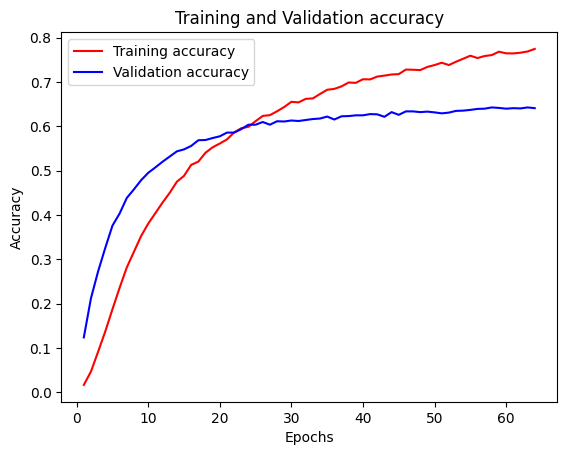

In [22]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plot_model_acc(num_epochs=64, train_acc=acc_train, val_acc=acc_val)

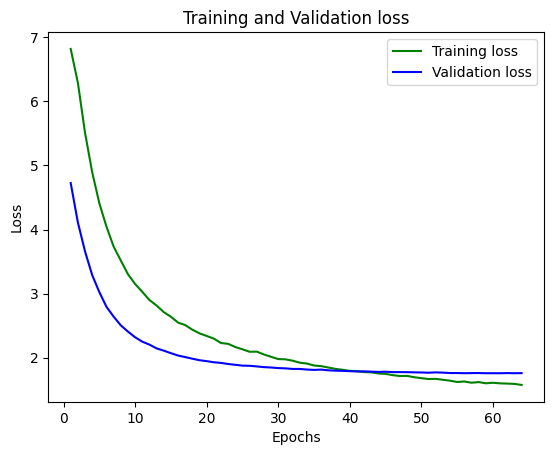

In [24]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plot_model_loss(num_epochs=64, train_loss=loss_train, val_loss=loss_val)

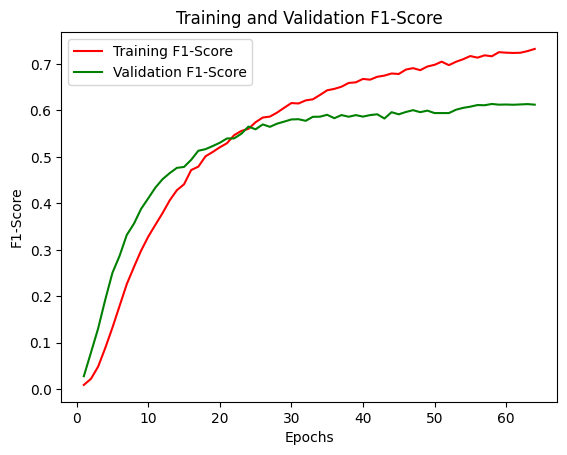

In [25]:
x_axis = range(1,64+1)
plt.plot(x_axis, history.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

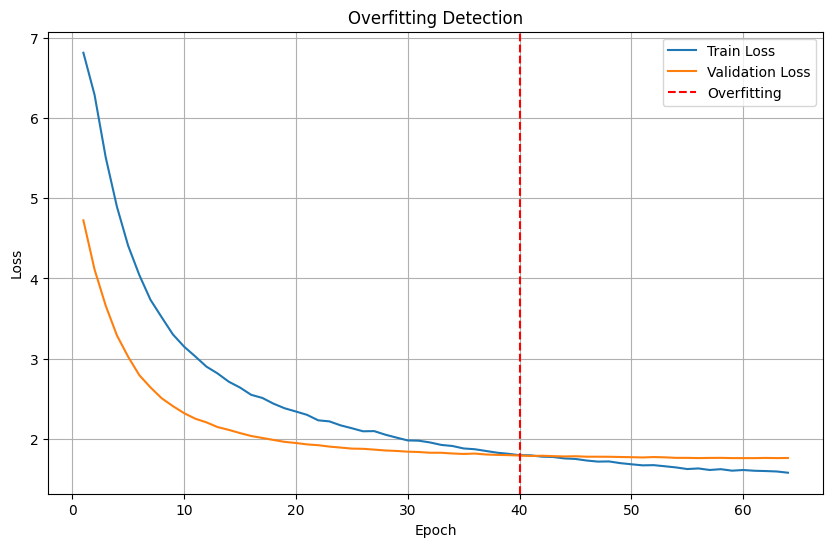

In [30]:
epochs = range(1, len(loss_train) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train, label='Train Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.axvline(x=40, color='r', linestyle='--', label='Overfitting')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overfitting Detection')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
epochs = range(1, len(loss_train) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train, label='Train Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.axvline(x=40, color='r', linestyle='--', label='Overfitting')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overfitting Detection')
plt.legend()
plt.grid(True)
plt.show()

### Train until overfit

In [17]:
input_img = Input(shape=(224, 224, 3))
base_model_cont = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)

for layer in base_model_cont.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model_cont.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model_cont = models.Model(inputs=base_model_cont.input, outputs=x)

model_cont.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)


In [ ]:
experiment = Experiment(
    model=model_cont,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_with_preprocessing_running_to_32_epochs_with_batch_size_corrected_with_label_smoothing_001",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,           # Reduce LR if no improvement after 2 epochs
        min_lr=1e-6,
        verbose=1
    )]
    
# Run the experiment
history_cont= experiment.run_experiment(callbacks=callbacks_additional, epochs=50) # callbacks=None use default callbacks (created in the Experiment class)

No checkpoint found, starting from scratch.
Epoch 1/50


/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_179']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.0166 - auc: 0.5435 - f1_score: 0.0072 - loss: 6.9180

2025-04-15 09:39:13.837945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_179']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


350/350 ━━━━━━━━━━━━━━━━━━━━ 108s 303ms/step


2025-04-15 09:41:02.407311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_179']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 255s 716ms/step - accuracy: 0.0166 - auc: 0.5435 - f1_score: 0.0072 - loss: 6.9181 - val_accuracy: 0.1441 - val_auc: 0.7243 - val_f1_score: 0.0266 - val_loss: 4.8349 - learning_rate: 1.0000e-04
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.0599 - auc: 0.5914 - f1_score: 0.0194 - loss: 6.5137

2025-04-15 09:43:46.192696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 107s 304ms/step


2025-04-15 09:45:33.485520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 270s 773ms/step - accuracy: 0.0599 - auc: 0.5914 - f1_score: 0.0194 - loss: 6.5133 - val_accuracy: 0.2104 - val_auc: 0.7874 - val_f1_score: 0.0600 - val_loss: 4.2354 - learning_rate: 1.0000e-04
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.1122 - auc: 0.6185 - f1_score: 0.0372 - loss: 5.7323

2025-04-15 09:48:15.375879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 266s 760ms/step


2025-04-15 09:52:41.665840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.1122 - auc: 0.6185 - f1_score: 0.0372 - loss: 5.7319 - val_accuracy: 0.2649 - val_auc: 0.8317 - val_f1_score: 0.1008 - val_loss: 3.7746 - learning_rate: 1.0000e-04
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.1570 - auc: 0.6493 - f1_score: 0.0603 - loss: 5.0740

2025-04-15 09:55:26.328001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 110s 314ms/step


2025-04-15 09:57:17.109017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 262ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 276s 788ms/step - accuracy: 0.1571 - auc: 0.6493 - f1_score: 0.0603 - loss: 5.0737 - val_accuracy: 0.3127 - val_auc: 0.8667 - val_f1_score: 0.1422 - val_loss: 3.4321 - learning_rate: 1.0000e-04
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2012 - auc: 0.6680 - f1_score: 0.0909 - loss: 4.6149

2025-04-15 10:00:01.059062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step


2025-04-15 10:06:35.390981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 560s 2s/step - accuracy: 0.2013 - auc: 0.6680 - f1_score: 0.0909 - loss: 4.6146 - val_accuracy: 0.3495 - val_auc: 0.8893 - val_f1_score: 0.1910 - val_loss: 3.1579 - learning_rate: 1.0000e-04
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.2451 - auc: 0.6922 - f1_score: 0.1235 - loss: 4.1912

2025-04-15 10:10:17.005442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 109s 310ms/step


2025-04-15 10:12:06.550740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 257ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 328s 938ms/step - accuracy: 0.2452 - auc: 0.6922 - f1_score: 0.1236 - loss: 4.1910 - val_accuracy: 0.3817 - val_auc: 0.9056 - val_f1_score: 0.2234 - val_loss: 2.9513 - learning_rate: 1.0000e-04
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.2924 - auc: 0.7045 - f1_score: 0.1617 - loss: 3.8585

2025-04-15 10:14:49.842170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 108s 308ms/step


2025-04-15 10:16:38.662970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 274s 784ms/step - accuracy: 0.2924 - auc: 0.7045 - f1_score: 0.1617 - loss: 3.8583 - val_accuracy: 0.4107 - val_auc: 0.9174 - val_f1_score: 0.2640 - val_loss: 2.7967 - learning_rate: 1.0000e-04
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.3251 - auc: 0.7179 - f1_score: 0.1908 - loss: 3.5921

2025-04-15 10:19:42.809637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 141s 400ms/step


2025-04-15 10:22:04.223841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 312ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 330s 943ms/step - accuracy: 0.3251 - auc: 0.7179 - f1_score: 0.1908 - loss: 3.5920 - val_accuracy: 0.4313 - val_auc: 0.9265 - val_f1_score: 0.2883 - val_loss: 2.6695 - learning_rate: 1.0000e-04
Epoch 9/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3576 - auc: 0.7259 - f1_score: 0.2275 - loss: 3.3862

2025-04-15 10:25:45.413860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 122s 348ms/step


2025-04-15 10:27:48.440214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 339s 956ms/step - accuracy: 0.3576 - auc: 0.7259 - f1_score: 0.2275 - loss: 3.3861 - val_accuracy: 0.4591 - val_auc: 0.9343 - val_f1_score: 0.3279 - val_loss: 2.5504 - learning_rate: 1.0000e-04
Epoch 10/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4006 - auc: 0.7358 - f1_score: 0.2655 - loss: 3.1881

2025-04-15 10:31:20.320884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 141s 398ms/step


2025-04-15 10:33:42.335938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 331ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.4006 - auc: 0.7358 - f1_score: 0.2656 - loss: 3.1880 - val_accuracy: 0.4775 - val_auc: 0.9422 - val_f1_score: 0.3487 - val_loss: 2.4595 - learning_rate: 1.0000e-04
Epoch 11/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.4125 - auc: 0.7406 - f1_score: 0.2810 - loss: 3.0435

2025-04-15 10:37:21.274810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 154s 427ms/step


2025-04-15 10:39:56.272851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.4125 - auc: 0.7406 - f1_score: 0.2811 - loss: 3.0434 - val_accuracy: 0.4942 - val_auc: 0.9428 - val_f1_score: 0.3737 - val_loss: 2.3976 - learning_rate: 1.0000e-04
Epoch 12/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4327 - auc: 0.7465 - f1_score: 0.3067 - loss: 2.9326

2025-04-15 10:58:36.621454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 170s 484ms/step


2025-04-15 11:01:28.229888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 55s 675ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 1319s 4s/step - accuracy: 0.4327 - auc: 0.7465 - f1_score: 0.3068 - loss: 2.9325 - val_accuracy: 0.5003 - val_auc: 0.9442 - val_f1_score: 0.3795 - val_loss: 2.3423 - learning_rate: 1.0000e-04
Epoch 13/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.4644 - auc: 0.7511 - f1_score: 0.3393 - loss: 2.8240

In [ ]:
experiment.model.save("resnet50_with_preprocessing_running_to_32_epochs_with_batch_size_corrected_and_label_smoothing.keras")

NameError: name 'experiment' is not defined

In [18]:
pd.DataFrame(history_cont.history).to_csv("resnet50_with_preprocessing_running_to_32_epochs.csv", index=False)

NameError: name 'history_cont' is not defined

### Fine-tune

In [13]:
model_ft = load_model("resnet50_with_preprocessing_running_to_32_epochs.keras", compile=False)

In [24]:
trainable = False
for layer in model_ft.layers:
    if "conv5_block1_1_conv" in layer.name:
        trainable = True
    layer.trainable = trainable

model_ft.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=metrics
)

In [27]:
experiment = Experiment(
    model=model_ft,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_with_preprocessing_finetuning_phase_v2",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_finetune = [
    ReduceLROnPlateau(monitor='val_f1_score', mode='max', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True, verbose=1)
]
    
# Run the experiment
history_finetune = model_ft.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # ou até 15 no máximo
    callbacks=callbacks_finetune
)

Epoch 1/10


2025-04-14 10:16:55.870900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


263/263 ━━━━━━━━━━━━━━━━━━━━ 241s 884ms/step - accuracy: 0.5315 - auc: 0.7484 - f1_score: 0.4691 - loss: 2.6221 - val_accuracy: 0.6055 - val_auc: 0.9643 - val_f1_score: 0.5687 - val_loss: 1.8210 - learning_rate: 1.0000e-05
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 204s 767ms/step - accuracy: 0.5971 - auc: 0.7568 - f1_score: 0.5305 - loss: 2.2911 - val_accuracy: 0.6188 - val_auc: 0.9647 - val_f1_score: 0.5800 - val_loss: 1.7869 - learning_rate: 1.0000e-05
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 194s 739ms/step - accuracy: 0.6319 - auc: 0.7610 - f1_score: 0.5574 - loss: 2.1379 - val_accuracy: 0.6210 - val_auc: 0.9646 - val_f1_score: 0.5816 - val_loss: 1.7488 - learning_rate: 1.0000e-05
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 195s 740ms/step - accuracy: 0.6825 - auc: 0.7646 - f1_score: 0.6036 - loss: 1.9791 - val_accuracy: 0.6277 - val_auc: 0.9644 - val_f1_score: 0.5920 - val_loss: 1.7173 - learning_rate: 1.0000e-05
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 200s 760ms/step - accuracy: 0.7034 

In [14]:
test_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/test",
    minority_class=minority_class,
    augment=None,
    preprocessing_function=preprocess_input
)

Found 1798 files belonging to 202 classes.


In [22]:
model_ft = load_model("resnet50_with_preprocessing_running_to_32_epochs.keras", compile=False)
model_ft.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=metrics
)

In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Get true labels
y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_true = np.argmax(y_true, axis=1)

# Get predicted probabilities
y_pred_probs = model_ft.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Métricas principais
print(classification_report(y_true, y_pred, digits=3))
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))


2025-04-14 11:37:29.719630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step
              precision    recall  f1-score   support

           0      0.667     0.667     0.667        18
           1      0.400     0.429     0.414        14
           2      0.549     0.875     0.675        32
           3      0.333     0.111     0.167         9
           4      0.407     0.611     0.489        18
           5      1.000     0.250     0.400         4
           6      1.000     0.200     0.333         5
           7      0.333     0.250     0.286         4
           8      0.500     0.111     0.182         9
           9      0.500     0.333     0.400         9
          10      0.630     0.630     0.630        27
          11      0.800     0.444     0.571         9
          12      0.833     0.556     0.667         9
          13      0.913     0.913     0.913        23
          14      0.857     0.667     0.750         9
          15      0.000     0.000     0.000         5
          16      0.522     0.522     0

/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.7396..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-109.54765..145.23947].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-100.94433..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..144.4896].
Clipping 

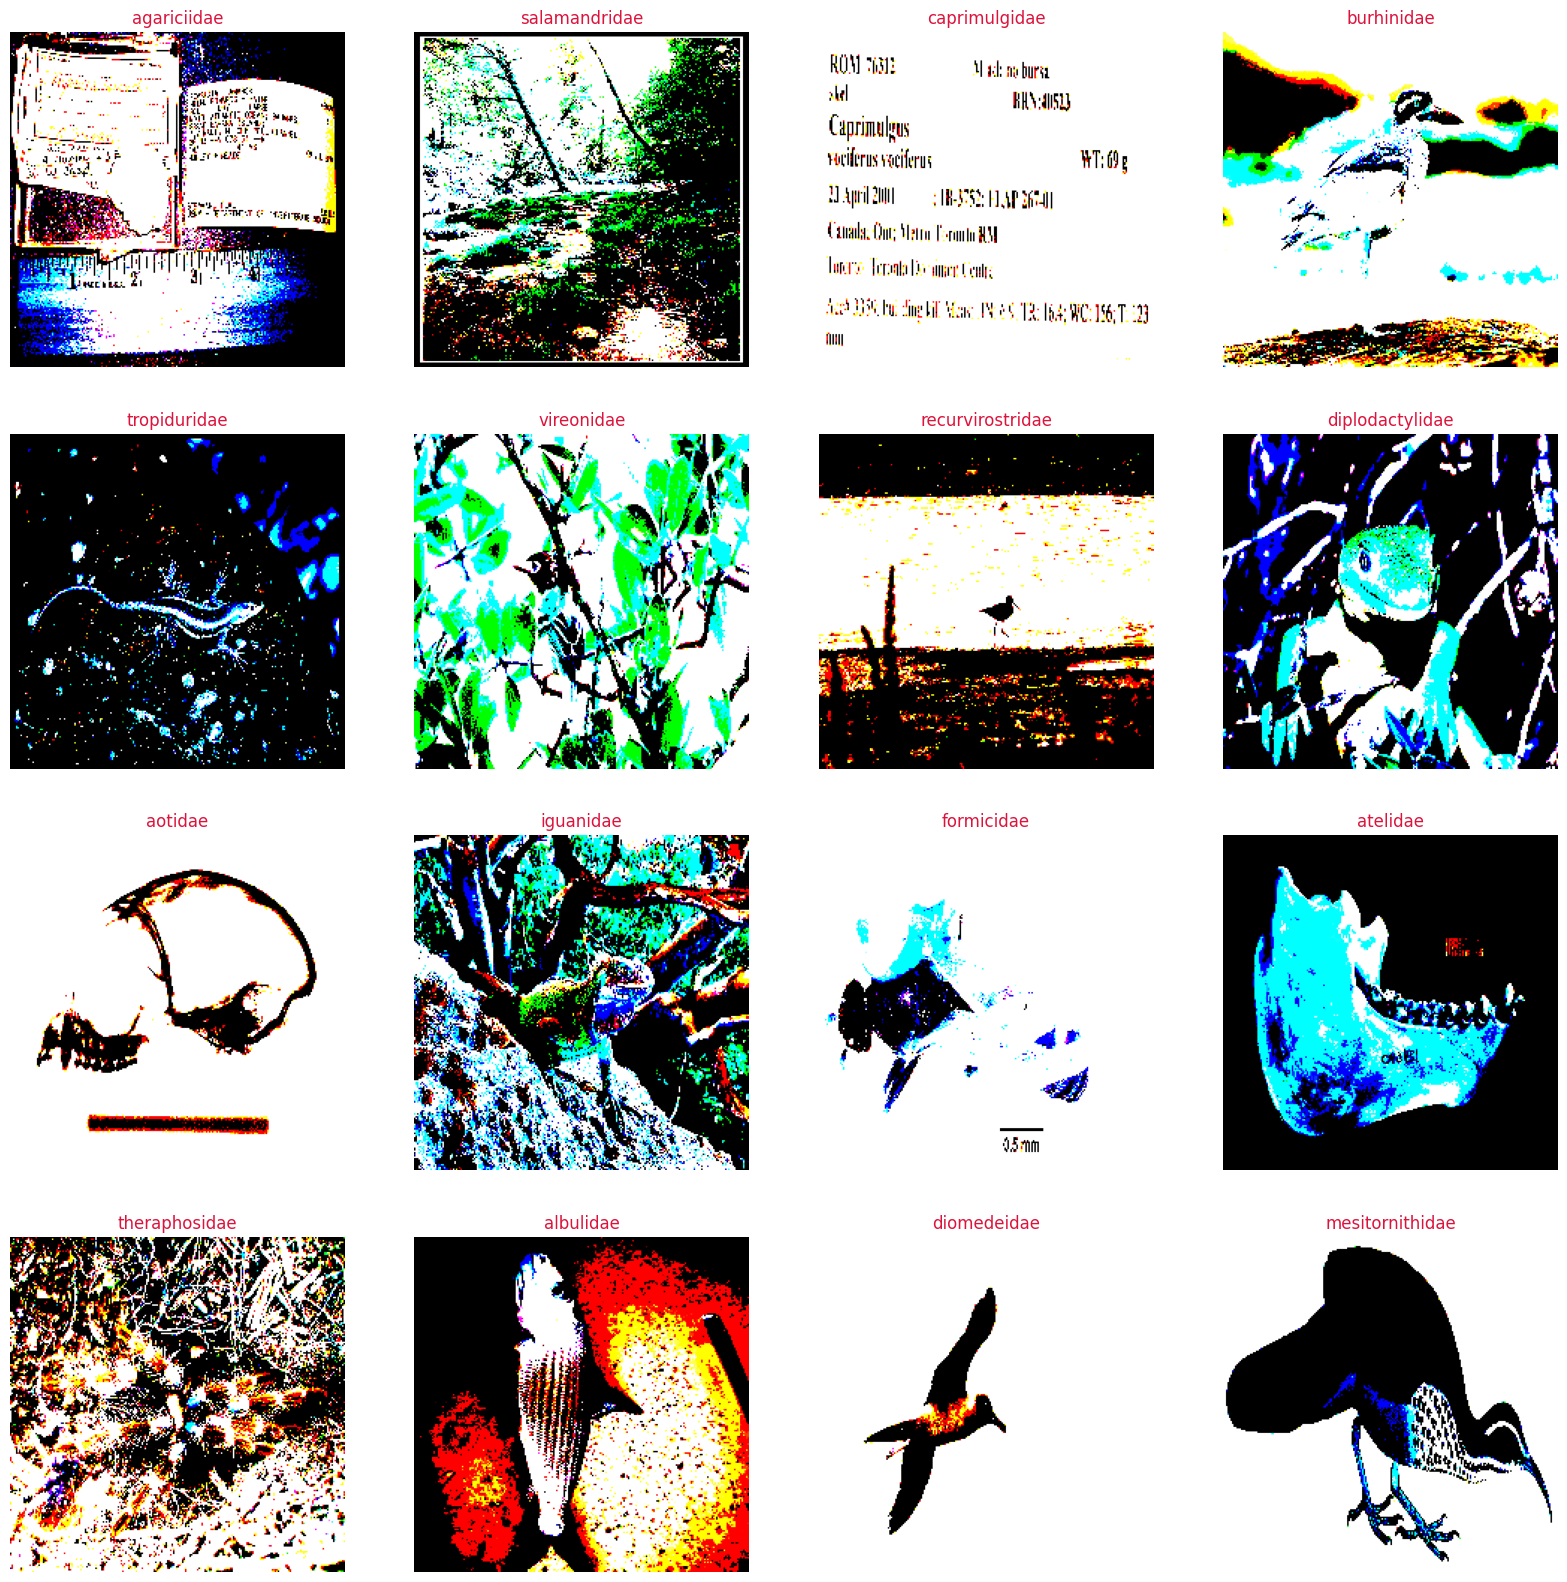

In [ ]:
num_images = 16 ##
rows, cols = 4, 4 ##



In [26]:

history = model.fit(train_ds, epochs=50, batch_size=32, validation_data=val_ds, callbacks=callbacks)

NameError: name 'callbacks' is not defined

In [ ]:

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

## EfficientNet

In [ ]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

#initial_lr = 1e-4  
#final_lr = 1e-5
n_epochs = 50
#my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)


callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run2.csv",
#   lr_scheduler=my_scheduler_fn
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Número de classes (families) — substitui com o teu número real
num_classes = len(df['family'].unique())

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True

# congela só as primeiras camadas
for layer in base_model.layers[:150]:
    layer.trainable = False

# Topo personalizado
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(202, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)

# Compilar
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("checkpoints/model.keras", monitor='val_loss', save_best_only=True),
    CSVLogger("logs/run2.csv")
]

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 165s 565ms/step - acc: 0.0135 - auc: 0.5654 - f1_score: 0.0047 - loss: 7.3565 - val_acc: 0.0173 - val_auc: 0.6483 - val_f1_score: 1.6791e-04 - val_loss: 5.1712
Epoch 2/30
 86/263 ━━━━━━━━━━━━━━━━━━━━ 1:28 502ms/step - acc: 0.0171 - auc: 0.5969 - f1_score: 0.0028 - loss: 5.9324

KeyboardInterrupt: 